# Initial test runs
This experiments seeks to test whether CALVADOS 2 is viable for simulating histone IDRs.

In [1]:
# Imports
from tqdm import tqdm
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils

## Data preparation

### Templates

In [51]:
# Defining UniProt IDs / Trivial IDs
uids = ['P07305', 'B4DR52']
ids = ['H1-0', 'H2B']
templates = pd.DataFrame({'uniprot_id': uids,
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=ids)

In [53]:
# Collecting metadata
for id, row in tqdm(templates.iterrows()):
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

2it [00:00,  5.18it/s]


In [60]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
H2B,B4DR52,B4DR52_HUMAN,Histone H2B,Homo sapiens (Human),MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVL...


In [61]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Variants

In [36]:
# Getting template metadata
with open('initial.json', 'r') as file:
    metadata = json.load(file)

In [63]:
# Generating all variant types
variants = list(data_utils.variant_types.keys())

In [64]:
# Getting longest IDR
length_order=True
i_idr=0

In [65]:
# Getting IDR regions
IDRs = []
for id, fields in tqdm(metadata['templates'].items()):
    seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
    IDRs.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
data = pd.DataFrame(IDRs)

  0%|          | 0/2 [00:00<?, ?it/s]/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


In [66]:
# Expanding dataframe to include all variants
data['variant'] = [variants]*len(data)
data = data.explode('variant')
data.index = data['template'] + '_' + data['variant'].str.upper()

# Generating variant sequence
data['sequence'] = data.apply(lambda row: data_utils.generate_variant(row['sequence'], row['variant']), axis=1)

# Setting variant description
data['variant'] = data.apply(lambda row: data_utils.variant_types[row['variant']]['name'], axis=1)

In [67]:
# Viewing final data
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
H1-0_RAND,H1-0,PTKKTDSAKVVTKKPKATEKAKPAKKSAASAFKTKAVPKGRKKKKK...,83:194,CTD,Randomly shuffled
H1-0_CLUST,H1-0,KKKKKKRKKKRKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges
H2B_WT,H2B,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKE,0:36,NTD,Wild type
H2B_RAND,H2B,SDPPKVAQRKPDPKGKVASKESAKMGRKKTRKKKKA,0:36,NTD,Randomly shuffled
H2B_CLUST,H2B,KKRKKKKKKKKKRRKAPAVTSVQPMSGPAPAGSDDE,0:36,NTD,Terminally clustered charges


In [ ]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [ ]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

## Analysis

In [2]:
# Loading metadata
metadata = analyse_utils.load_metadata('initial.json')
metadata

,template,sequence,location,region,variant,uniprot_id,name,species,description
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type,P07305,H10_HUMAN,Homo sapiens (Human),Histone H1.0
H1-0_RAND,H1-0,PGTKKPKSTKTKKALAKAKKAKVKGSKAEKATSAAKKSVKPKKSKA...,83:194,CTD,Randomly shuffled,P07305,H10_HUMAN,Homo sapiens (Human),Histone H1.0
H1-0_CLUST,H1-0,KKKKKKKKKKRKKKKKKKKKKKKKKKKKKKKKRKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges,P07305,H10_HUMAN,Homo sapiens (Human),Histone H1.0
H2B_WT,H2B,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRK,0:36,NTD,Wild type,B4DR52,B4DR52_HUMAN,Homo sapiens (Human),Histone H2B
H2B_RAND,H2B,EKKKKSDMKPKRKPVASQAAKPKSRKKKTPGRGAA,0:36,NTD,Randomly shuffled,B4DR52,B4DR52_HUMAN,Homo sapiens (Human),Histone H2B
H2B_CLUST,H2B,RKRKKKKKKKRKKKKASAVTAAQGPPGSAPPMSED,0:36,NTD,Terminally clustered charges,B4DR52,B4DR52_HUMAN,Homo sapiens (Human),Histone H2B


In [3]:
# Loading trajectories
metadata['traj'] = metadata.apply(lambda row: md.load_dcd(*['/'.join(['results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

### CIDER parameters

More on CIDER from Pappu Lab:
- [CIDER](http://pappulab.wustl.edu/CIDER/about/)
- [localCIDER](http://pappulab.github.io/localCIDER/)

In [129]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata['sequence'])
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.,Length,Charge
H1-0_WT,0.154432,0.432432,0.378378,3.249550,0.891892,111,42
H1-0_RAND,0.217323,0.432432,0.378378,3.249550,0.891892,111,42
H1-0_CLUST,0.994959,0.432432,0.378378,3.249550,0.891892,111,42
H2B_WT,0.301676,0.485714,0.371429,2.682857,0.914286,35,13
H2B_RAND,0.299729,0.485714,0.371429,2.614286,0.942857,35,13
H2B_CLUST,0.965685,0.485714,0.371429,2.614286,0.942857,35,13


### Structural descriptors

In [125]:
struc = pd.DataFrame(index=metadata.index)

In [130]:
# Computing radius of gyration
struc['Rg'] = metadata.apply(lambda row: analyse_utils.compute_rg(row.sequence, row.traj), axis=1)
struc['<Rg>'] = struc.apply(lambda row: row.Rg.mean(), axis=1)

In [141]:
# Computing end-to-end distance
struc['Re'] = metadata.apply(lambda row: md.compute_distances(row.traj, [[0, row.traj.n_atoms-1]]), axis=1)
struc['<Re>'] = struc.apply(lambda row: row.Re.mean(), axis=1)

In [132]:
# Computing asphericity
struc['b'] = metadata.apply(lambda row: md.asphericity(row.traj), axis=1)
struc['<b>'] = struc.apply(lambda row: row.b.mean(), axis=1)

In [138]:
# Computing acylindricity
struc['c'] = metadata.apply(lambda row: md.acylindricity(row.traj), axis=1)
struc['<c>'] = struc.apply(lambda row: row.c.mean(), axis=1)

In [139]:
# Computing shape relative anisotropy
struc['k'] = metadata.apply(lambda row: md.relative_shape_antisotropy(row.traj), axis=1)
struc['<k>'] = struc.apply(lambda row: row.k.mean(), axis=1)

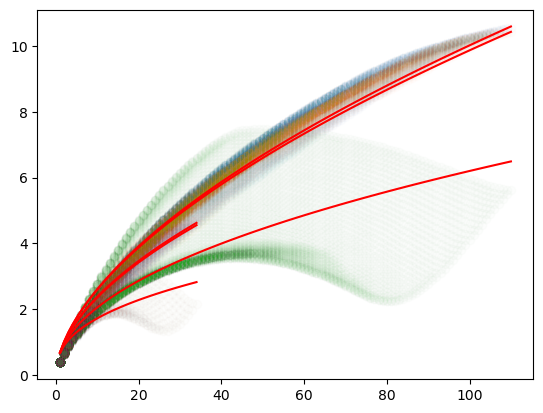

In [149]:
# Computing scaling exponent
struc['v'] = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, plot=True, r0_fix=0.68, ij_cutoff=10)[0], axis=1)

In [150]:
# Displaying means
struc[[*struc.columns[struc.columns.str.contains('<')], 'v']]

,<Re>,<Rg>,<b>,<c>,<k>,v
H1-0_WT,10.555419,4.238999,13.360721,1.944063,0.503509,0.584180
H1-0_RAND,10.439872,4.192798,13.021407,1.907514,0.501866,0.580877
H1-0_CLUST,5.635416,3.001981,5.295035,1.066699,0.364849,0.480004
H2B_WT,4.734719,1.894172,2.577944,0.363247,0.522335,0.543716
H2B_RAND,4.583144,1.841847,2.513140,0.359365,0.519316,0.539363
H2B_CLUST,2.148254,1.387353,1.092680,0.266815,0.340318,0.403844


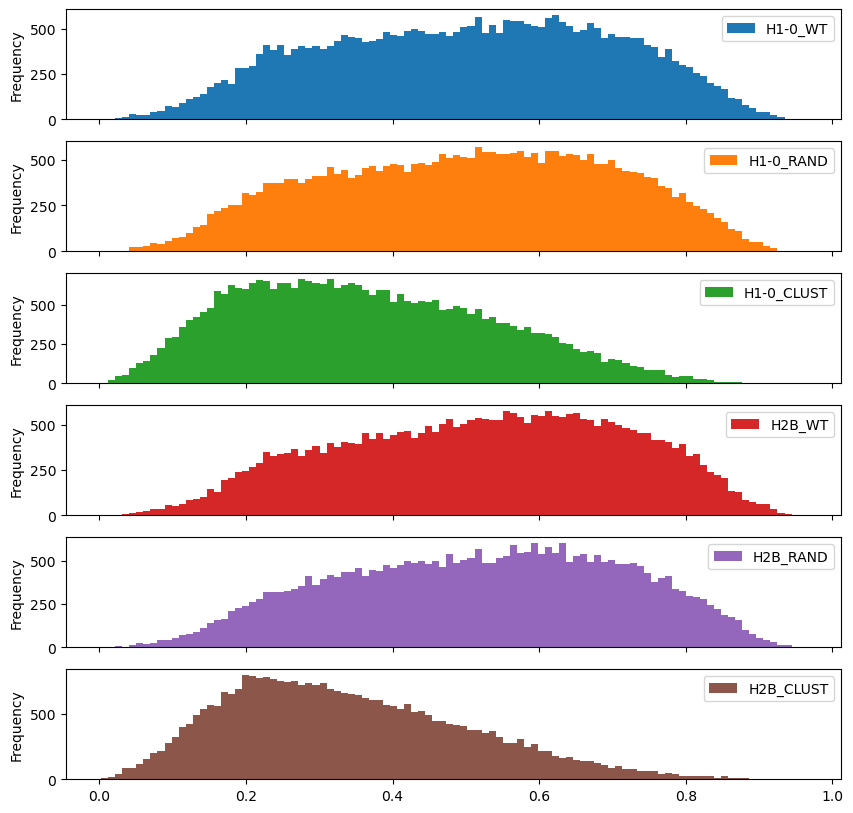

In [211]:
# Plotting distributions
measure = 'k'
axes = struc[[measure]].transpose().explode([*struc.index]).astype(float).plot.hist(bins=100, subplots=True, figsize=(10,10))

### Contact maps

In [4]:
# Choosing single variant as example
example = metadata.loc['H1-0_WT']

In [43]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(example.traj)

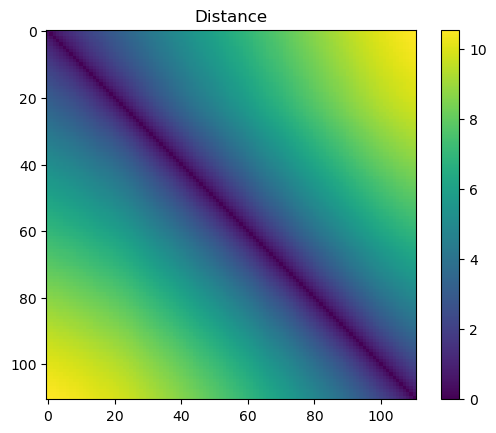

In [45]:
# Plotting distance contact map
plt.imshow(distances.mean(axis=0))
plt.title("Distance")
plt.colorbar()

In [6]:
# Calculating interaction energies
energies = {'Ashbaugh-Hatch': 'AH',
            'Debye-Hückel': 'DH',
            'Harmonic': 'HB'}
for p, e in energies.items():
    energies[p] = analyse_utils.compute_energy(example.sequence, example.traj, potentials=[e])
    energies[p] = md.geometry.squareform(energies[p].T, example.traj.top.select_pairs('all','all'))

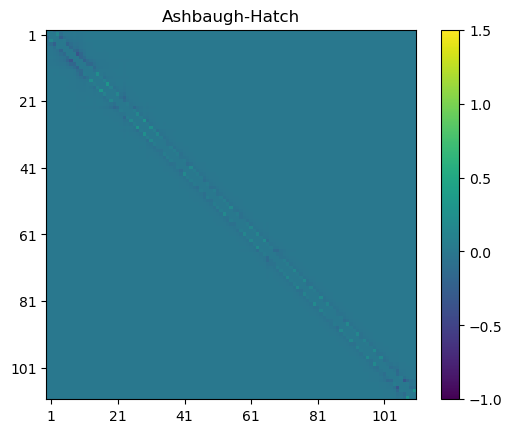

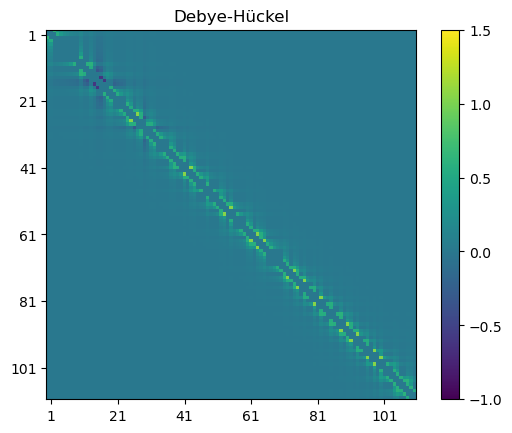

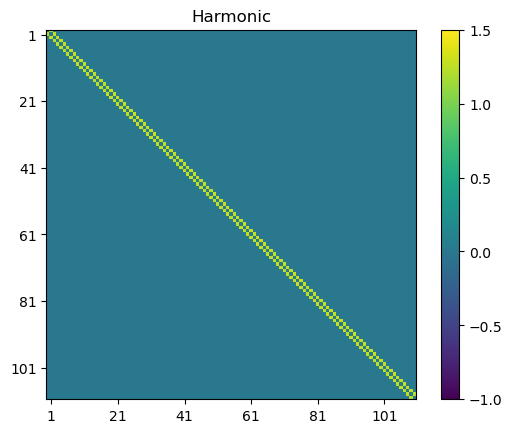

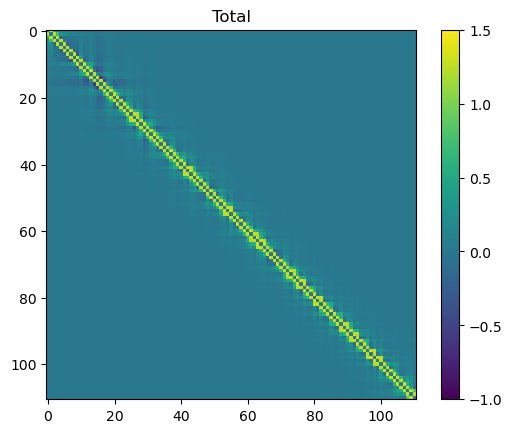

In [41]:
# Plotting energy contact maps
seqnum = range(1, len(example.sequence)+1, 20)
for p, e in energies.items():
    plt.imshow(e.mean(axis=0), vmin=-1, vmax=1.5)
    plt.xticks(seqnum)
    plt.yticks(seqnum)
    plt.title(p)
    plt.colorbar()
    plt.show()

plt.imshow(sum(energies.values()).mean(axis=0), vmin=-1, vmax=1.5)
plt.title("Total")
plt.colorbar()
plt.show()

### Drawing sequence

In [30]:
# Mapping sequence by charge
mapseq = []
for aa in example.sequence:
    if aa in ['D', 'E']:
        mapseq.append(-1)
    elif aa in ['K', 'R']:
        mapseq.append(1)
    else:
        mapseq.append(0)

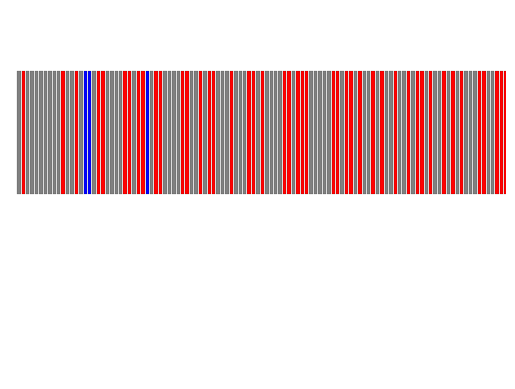

In [34]:
# Create a figure and axes object
fig, ax = plt.subplots()

# Set the axis limits
ax.set_xlim([-1, len(mapseq)])
ax.set_ylim([-1.5, 1.5])

# Loop over the numbers and plot them as vertical bars
for i, num in enumerate(mapseq):
    color = {-1: 'blue', 0: 'grey', 1: 'red'}[num]
    ax.bar(i, 1, color=color, edgecolor='black', linewidth=0.1,)

# Hide the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()